# Laboratorio 8
Desafío: Aprendizaje por Refuerzo en Brazo Robótico para Manipulación de Objetos

In [2]:
import os
import time
import numpy as np
import pybullet as p
import pybullet_data
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv


## Definición del entorno RoboticArmEnv
Se define una clase personalizada para el entorno del brazo robótico, que hereda de `gym.Env`. Esta clase contiene los métodos necesarios para iniciar, reiniciar y simular episodios del agente. Se usa PyBullet para la simulación física del brazo KUKA con 3 grados de libertad y un vaso cilíndrico como objeto a manipular.

In [3]:
class RoboticArmEnv(gym.Env):
    def __init__(self, render=False):
        super(RoboticArmEnv, self).__init__()
        self.render_mode = render
        self.time_step = 1. / 240.
        self.max_steps = 1000
        self.step_counter = 0
        self.episode_counter = 0

        self.action_space = spaces.Box(low=-np.pi, high=np.pi, shape=(3,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

        if p.isConnected():
            p.disconnect()

        if self.render_mode:
            self.physicsClient = p.connect(p.GUI)
        else:
            self.physicsClient = p.connect(p.DIRECT)

        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.8)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_counter = 0
        p.resetSimulation()
        p.setGravity(0, 0, -9.8)
        p.loadURDF("plane.urdf")

        self.cup_position = [0.2, 0, 0.075]
        cup_collision = p.createCollisionShape(p.GEOM_CYLINDER, radius=0.05, height=0.15)
        cup_visual = p.createVisualShape(p.GEOM_CYLINDER, radius=0.05, length=0.15, rgbaColor=[1, 1, 0, 1])
        self.cup_id = p.createMultiBody(baseMass=0.2,
                                        baseCollisionShapeIndex=cup_collision,
                                        baseVisualShapeIndex=cup_visual,
                                        basePosition=self.cup_position)

        p.changeDynamics(self.cup_id, -1,
                         lateralFriction=0.4,
                         restitution=0.3,
                         rollingFriction=0.01,
                         spinningFriction=0.01)

        kuka_path = os.path.join(os.getcwd(), "kuka_iiwa_3dof", "model.urdf")
        self.arm_id = p.loadURDF(kuka_path, useFixedBase=True)
        self.num_joints = p.getNumJoints(self.arm_id)

        return self._get_obs(), {}

    def _get_obs(self):
        joint_states = [p.getJointState(self.arm_id, i)[0] for i in range(3)]
        cup_pos, _ = p.getBasePositionAndOrientation(self.cup_id)
        return np.array(joint_states + list(cup_pos), dtype=np.float32)

    def step(self, action):
        self.step_counter += 1

        # Aplicar la acción
        for i in range(3):
            p.setJointMotorControl2(self.arm_id, i, p.POSITION_CONTROL, targetPosition=action[i])
        p.stepSimulation()
        if self.render_mode:
            time.sleep(self.time_step)

        # Obtener estados
        cup_pos, _ = p.getBasePositionAndOrientation(self.cup_id)
        ee_pos = p.getLinkState(self.arm_id, 2)[0]
        distance = np.linalg.norm(np.array(cup_pos) - np.array(ee_pos))
        reward = 1.0 - distance

        if distance < 0.05:
            reward += 5

        # Detectar caída del vaso
        if cup_pos[2] < 0.03:
            reward += 10
            self.episode_counter += 1
            obs, _ = self.reset()  # reiniciar automáticamente
            return obs, reward, False, False, {}

        done = self.step_counter >= self.max_steps
        return self._get_obs(), reward, done, False, {}

    def close(self):
        p.disconnect()

# Verificación del entorno

Se crea una instancia del entorno y se valida su estructura usando `check_env` de Stable Baselines3, para asegurarse de que cumple con los requerimientos del framework de RL.

In [4]:
env = RoboticArmEnv(render=False)
check_env(env)
env.close()

c:\Users\OMEN\anaconda3\Lib\site-packages\stable_baselines3\common\env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [5]:
env = DummyVecEnv([lambda: RoboticArmEnv(render=False)])
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)
model.save("ppo_robotic_arm_3dof")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1861 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1310        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009285082 |
|    clip_fraction        | 0.0582      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | 0.0202      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.89        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00755    |
|    std                  | 0.999       |
|    value_loss           | 74.1        |
-----------------

In [6]:
import imageio
import pybullet as p

In [7]:
env = RoboticArmEnv(render=False)
model = PPO.load("ppo_robotic_arm_3dof")
obs, _ = env.reset()

frames = []

# Capturar 200 pasos de simulación
for _ in range(200):
    img_arr = p.getCameraImage(
        width=640, height=480,
        viewMatrix=p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0, 0, 0.2],
                                                       distance=1.2,
                                                       yaw=45, pitch=-30, roll=0,
                                                       upAxisIndex=2),
        projectionMatrix=p.computeProjectionMatrixFOV(fov=60, aspect=1.0, nearVal=0.01, farVal=2.0)
    )[2]  # Solo el RGB array

    # Guardar frame
    frames.append(img_arr)

    # Simulación paso a paso
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)

env.close()

# Guardar como GIF
imageio.mimsave("simulacion_brazo.gif", frames, fps=30)
print("GIF guardado como simulacion_brazo.gif")


GIF guardado como simulacion_brazo.gif


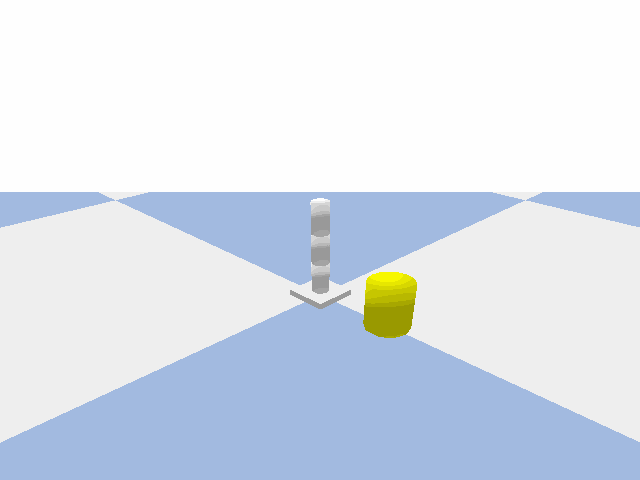

In [8]:
from IPython.display import Image

# Mostrar el GIF en la celda del notebook
Image(filename="simulacion_brazo.gif")
